In [112]:
#To import all required modules
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
import os
import pandas as pd
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import *
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import col, udf
import matplotlib.pyplot as plt
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

In [83]:
spark = SparkSession.builder.appName("ml").getOrCreate()


In [84]:
# Loading the dataset
tweets_dataFrame = spark.read.load("dataset/tweets_dataset_v2.csv", format="csv", header=True, inferSchema=True, delimiter=",")
# Check the type of tweets_dataFrame
print("The type of tweets_dataFrame is", type(tweets_dataFrame))
#To show the first 3 rows
pd.DataFrame(tweets_dataFrame.take(3), columns=tweets_dataFrame.columns).transpose()

The type of tweets_dataFrame is <class 'pyspark.sql.dataframe.DataFrame'>


,0,1,2
_c0,0,1,2
text,Beats by Dr Dre urBeats Wired In Ear Headphone...,Man it would fucking rule if we had a party t...,It is time to draw close to Him 128591 127995 ...
id,1,2,3
category,spam,abusive,normal
numberOfAnnotators,4,4,4


In [85]:
#To get text, id, label attributes only
#To create a temporary view of data frame to use with spark sql
tweets_dataFrame.createOrReplaceTempView("tweets")
tweets_dataFrame2 = spark.sql("SELECT id, category, text FROM tweets WHERE (category=='spam' OR category=='abusive' OR category=='normal' OR category=='hateful')")
tweets_dataFrame2.show(5)

+---+--------+--------------------+
| id|category|                text|
+---+--------+--------------------+
|  1|    spam|Beats by Dr Dre u...|
|  2| abusive| Man it would fuc...|
|  3|  normal|It is time to dra...|
|  4|  normal|if you notice me ...|
|  5|  normal|Forget unfollower...|
+---+--------+--------------------+
only showing top 5 rows



In [86]:
#To remove null values
for clmx in tweets_dataFrame2.columns:
    print(clmx)
    tweets_dataFrame2 = tweets_dataFrame2.filter(tweets_dataFrame2[clmx].isNotNull())

id
category
text


+--------+-----+
|category|count|
+--------+-----+
|  normal|52567|
| abusive|26823|
|    spam|13850|
| hateful| 4848|
+--------+-----+



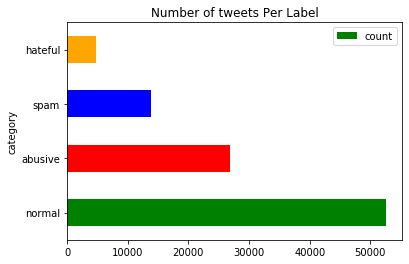

In [87]:
#To show number of tweets per label
number_of_tweets_per_label = tweets_dataFrame2.groupBy("category").count().orderBy(col("count").desc()) 
number_of_tweets_per_label.show()

#To plot the result 
result = number_of_tweets_per_label.toPandas()
result.plot(kind = "barh", x="category", y="count", color=['green','red','blue','orange'])
plt.title("Number of tweets Per Label")
plt.show()

In [88]:
#To apply Tokenization process to get twwet text and break it into individual terms (words)
tokenizer = Tokenizer(inputCol="text", outputCol="words")
tweets_dataFrame2 = tokenizer.transform(tweets_dataFrame2)


In [89]:
tweets_dataFrame2.show(5)

+---+--------+--------------------+--------------------+
| id|category|                text|               words|
+---+--------+--------------------+--------------------+
|  1|    spam|Beats by Dr Dre u...|[beats, by, dr, d...|
|  2| abusive| Man it would fuc...|[, man, it, would...|
|  3|  normal|It is time to dra...|[it, is, time, to...|
|  4|  normal|if you notice me ...|[if, you, notice,...|
|  5|  normal|Forget unfollower...|[forget, unfollow...|
+---+--------+--------------------+--------------------+
only showing top 5 rows



In [90]:
# To remove Stop words because the words appear frequently and don’t carry as much meaning
stop_word_remover = StopWordsRemover(inputCol="words", outputCol="filtered")
tweets_dataFrame2 = stop_word_remover.transform(tweets_dataFrame2)


In [91]:
tweets_dataFrame2.show(3)

+---+--------+--------------------+--------------------+--------------------+
| id|category|                text|               words|            filtered|
+---+--------+--------------------+--------------------+--------------------+
|  1|    spam|Beats by Dr Dre u...|[beats, by, dr, d...|[beats, dr, dre, ...|
|  2| abusive| Man it would fuc...|[, man, it, would...|[, man, fucking, ...|
|  3|  normal|It is time to dra...|[it, is, time, to...|[time, draw, clos...|
+---+--------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [92]:
# bag of words count
# fit a CountVectorizerModel from the corpus.
word_count_Vectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=5000, minDF=2.0)

vector_model = word_count_Vectors.fit(tweets_dataFrame2)

tweets_dataFrame2 = vector_model.transform(tweets_dataFrame2)


In [93]:
tweets_dataFrame2.show(3)

+---+--------+--------------------+--------------------+--------------------+--------------------+
| id|category|                text|               words|            filtered|            features|
+---+--------+--------------------+--------------------+--------------------+--------------------+
|  1|    spam|Beats by Dr Dre u...|[beats, by, dr, d...|[beats, dr, dre, ...|(5000,[191,954,14...|
|  2| abusive| Man it would fuc...|[, man, it, would...|[, man, fucking, ...|(5000,[0,1,54,302...|
|  3|  normal|It is time to dra...|[it, is, time, to...|[time, draw, clos...|(5000,[16,81,323,...|
+---+--------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [94]:
#to create a new column called label from the income attribute
indexer = StringIndexer(inputCol="category", outputCol="label") 
tweets_dataFrame2 = indexer.fit(tweets_dataFrame2).transform(tweets_dataFrame2)
tweets_dataFrame2.show(3)

+---+--------+--------------------+--------------------+--------------------+--------------------+-----+
| id|category|                text|               words|            filtered|            features|label|
+---+--------+--------------------+--------------------+--------------------+--------------------+-----+
|  1|    spam|Beats by Dr Dre u...|[beats, by, dr, d...|[beats, dr, dre, ...|(5000,[191,954,14...|  2.0|
|  2| abusive| Man it would fuc...|[, man, it, would...|[, man, fucking, ...|(5000,[0,1,54,302...|  1.0|
|  3|  normal|It is time to dra...|[it, is, time, to...|[time, draw, clos...|(5000,[16,81,323,...|  0.0|
+---+--------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 3 rows



In [95]:
tweets_dataFrame2.show(20)

+---+--------+--------------------+--------------------+--------------------+--------------------+-----+
| id|category|                text|               words|            filtered|            features|label|
+---+--------+--------------------+--------------------+--------------------+--------------------+-----+
|  1|    spam|Beats by Dr Dre u...|[beats, by, dr, d...|[beats, dr, dre, ...|(5000,[191,954,14...|  2.0|
|  2| abusive| Man it would fuc...|[, man, it, would...|[, man, fucking, ...|(5000,[0,1,54,302...|  1.0|
|  3|  normal|It is time to dra...|[it, is, time, to...|[time, draw, clos...|(5000,[16,81,323,...|  0.0|
|  4|  normal|if you notice me ...|[if, you, notice,...|[notice, start, a...|(5000,[3,111,187,...|  0.0|
|  5|  normal|Forget unfollower...|[forget, unfollow...|[forget, unfollow...|(5000,[13,17,23,9...|  0.0|
|  6| abusive| Hate Being sexua...|[, hate, being, s...|[, hate, sexually...|(5000,[0,2,29,33,...|  1.0|
|  7|  normal|opped the group i...|[opped, the, grou...

In [96]:
# To get the label and features vector
model_data = tweets_dataFrame2.select("id","category","text","words","filtered", "label","features")
#To split the model dataset into training and testing datasets, 80% for taining and 20% for testing
training, test = model_data.randomSplit([0.8, 0.2])

In [97]:
training.select("features").show()


+--------------------+
|            features|
+--------------------+
|(5000,[191,954,14...|
|(5000,[0,1,54,302...|
|(5000,[16,81,323,...|
|(5000,[3,111,187,...|
|(5000,[13,17,23,9...|
|(5000,[0,2,29,33,...|
|(5000,[15,267,462...|
|(5000,[233,237,25...|
|(5000,[15,30,186,...|
|(5000,[8,1309,181...|
|(5000,[8,40,104,1...|
|(5000,[0,1,8,60,8...|
|(5000,[13,314,546...|
|(5000,[107,184,20...|
|(5000,[0,1,11,111...|
|(5000,[470,2080],...|
|(5000,[42,661,683...|
|(5000,[0,1,66,313...|
|(5000,[441,531,17...|
|(5000,[1,52,413],...|
+--------------------+
only showing top 20 rows



In [102]:
#To train and predict text label using Logistic Regression
LogisticRegression_Model = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
LogisticRegression_Model = LogisticRegression_Model.fit(training)
predictions = LogisticRegression_Model.transform(test)
predictions.filter(predictions['prediction'] == 0).select("id","category","probability","label","prediction").orderBy("probability", ascending=False).show(n = 20, truncate = 30)

+-----+--------+------------------------------+-----+----------+
|   id|category|                   probability|label|prediction|
+-----+--------+------------------------------+-----+----------+
|48343|  normal|[0.9981093904032272,4.82024...|  0.0|       0.0|
|50735|  normal|[0.9835181703680428,0.00752...|  0.0|       0.0|
|53023|  normal|[0.9822302967225961,0.01109...|  0.0|       0.0|
|96644|  normal|[0.96973634437815,0.0132452...|  0.0|       0.0|
| 4922|  normal|[0.9672234375625904,0.00909...|  0.0|       0.0|
|52025|  normal|[0.9667019803679842,0.00859...|  0.0|       0.0|
|25231|  normal|[0.9651976890042367,0.01202...|  0.0|       0.0|
|10936| hateful|[0.9640574619516394,0.02186...|  3.0|       0.0|
|43716|  normal|[0.9640451963827754,0.00837...|  0.0|       0.0|
|50562|  normal|[0.9632788319785722,0.01249...|  0.0|       0.0|
|99818|  normal|[0.9613782435281926,0.01152...|  0.0|       0.0|
| 4811|  normal|[0.9589781067769243,0.01187...|  0.0|       0.0|
|90217|  normal|[0.958093

In [103]:
LogisticRegression_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("prediction Score for Logistic Regrassion model is: ")
LogisticRegression_evaluator.evaluate(predictions)

prediction Score for Logistic Regrassion model is: 


0.7474604569740025

In [109]:
#To train the Naïve Bayes model on the training dataset
NaiveBayes_model = NaiveBayes()
NaiveBayes_model = NaiveBayes_model.fit(training)

#To perform testing on the test dataset
NaiveBayes_predictions = NaiveBayes_model.transform(test)
print("To show prediction for some abusive tweets")
NaiveBayes_predictions.filter(NaiveBayes_predictions['prediction'] == 1).select("id","filtered","category","probability","label","prediction").orderBy("probability", ascending=False).show(n = 5, truncate = 30)
print("To show prediction for some hateful tweets")
NaiveBayes_predictions.filter(NaiveBayes_predictions['prediction'] == 3).select("id","filtered","category","probability","label","prediction").orderBy("probability", ascending=False).show(n = 5, truncate = 30)

To show prediction for some abusive tweets
+-----+------------------------------+--------+------------------------------+-----+----------+
|   id|                      filtered|category|                   probability|label|prediction|
+-----+------------------------------+--------+------------------------------+-----+----------+
|88281|[yeah, barrettes, aren, pla...| abusive|[0.4920481358947525,0.49283...|  1.0|       1.0|
|36399|[damn, maybe, excellent, ap...|  normal|[0.48712826480350646,0.4990...|  0.0|       1.0|
|91495|[mazzy, parents, need, go, ...|  normal|[0.48086533478628646,0.5011...|  0.0|       1.0|
|10501|[lutheran, yeah, answer, pe...|  normal|[0.47980794735477234,0.5118...|  0.0|       1.0|
|14164|[m, point, weight, cut, wai...|  normal|[0.4795949304645206,0.49383...|  0.0|       1.0|
+-----+------------------------------+--------+------------------------------+-----+----------+
only showing top 5 rows

To show prediction for some hateful tweets
+-----+------------------

In [110]:
# To evaluate model and compute accuracy on the test set
NaiveBayes_model_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = NaiveBayes_model_evaluator.evaluate(NaiveBayes_predictions)
print("Naive Bayes Model Accuracy = " + str(accuracy))

Naive Bayes Model Accuracy = 0.7637883576307473


In [111]:
#To train the Decision Tree model on the training dataset

DecisionTree_Model = DecisionTreeClassifier()
DecisionTree_Model = DecisionTree_Model.fit(training)
#To perform testing on the test dataset
DecisionTree_predictions = DecisionTree_Model.transform(test)
print("To show prediction for some abusive tweets")
DecisionTree_predictions.filter(DecisionTree_predictions['prediction'] == 1).select("id","filtered","category","probability","label","prediction").orderBy("probability", ascending=False).show(n = 5, truncate = 30)
print("To show prediction for some hateful tweets")
DecisionTree_predictions.filter(DecisionTree_predictions['prediction'] == 3).select("id","filtered","category","probability","label","prediction").orderBy("probability", ascending=False).show(n = 5, truncate = 30)

# To evaluate model and compute accuracy on the test set
DecisionTree_Model_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = DecisionTree_Model_evaluator.evaluate(DecisionTree_predictions)
print("Naive Bayes Model Accuracy = " + str(accuracy))

To show prediction for some abusive tweets
+-----+------------------------------+--------+------------------------------+-----+----------+
|   id|                      filtered|category|                   probability|label|prediction|
+-----+------------------------------+--------+------------------------------+-----+----------+
|69488|                    [, fucked]| abusive|[0.11568938193343899,0.7667...|  1.0|       1.0|
|69491|[, people, wanting, dislike...| abusive|[0.11568938193343899,0.7667...|  1.0|       1.0|
|69512|[, umm, yeah, lmaooooo, ret...| hateful|[0.11568938193343899,0.7667...|  3.0|       1.0|
|69537|                    [, fucked]| abusive|[0.11568938193343899,0.7667...|  1.0|       1.0|
|69581|[, 27, 30k, people, retweet...| abusive|[0.11568938193343899,0.7667...|  1.0|       1.0|
+-----+------------------------------+--------+------------------------------+-----+----------+
only showing top 5 rows

To show prediction for some hateful tweets
+-----+------------------

In [123]:
#Clustring
#To train the KMeans model on the training dataset
kmeans_model = KMeans().setK(4).setSeed(1)
kmeans_model = kmeans_model.fit(training)
#To perform testing on the test dataset
km_predictions = kmeans_model.transform(test)
print("To show prediction for some abusive tweets")
km_predictions.filter(km_predictions['label'] == 1).select("id","filtered","category","label","prediction").show(n = 5, truncate = 30)
print("To show prediction for some hateful tweets")
km_predictions.filter(km_predictions['label'] == 3).select("id","filtered","category","label","prediction").show(n = 5, truncate = 30)

# To evaluate model and compute accuracy on the test set
# Evaluate clustering by computing Silhouette score
evaluate_kmeans_model = ClusteringEvaluator()

silhouette = evaluate_kmeans_model.evaluate(km_predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


To show prediction for some abusive tweets
+---+------------------------------+--------+-----+----------+
| id|                      filtered|category|label|prediction|
+---+------------------------------+--------+-----+----------+
| 10|[, fucking, amp, homies, do...| abusive|  1.0|         1|
| 14|            [spotify, fucking]| abusive|  1.0|         1|
| 16|[, im, nasty, ass, freak, l...| abusive|  1.0|         1|
| 20|[ask, contact, picture, see...| abusive|  1.0|         0|
| 42|[, 100, see, bitches, mad, ...| abusive|  1.0|         1|
+---+------------------------------+--------+-----+----------+
only showing top 5 rows

To show prediction for some hateful tweets
+---+------------------------------+--------+-----+----------+
| id|                      filtered|category|label|prediction|
+---+------------------------------+--------+-----+----------+
| 22|[bad, day, kyrgyzstan, susp...| hateful|  3.0|         0|
| 35|[m, fucking, moon, ve, clea...| hateful|  3.0|         3|
|246|[a